<a href="https://colab.research.google.com/github/bernieee/SIRIUS/blob/master/AI_for_Med_image_analysis/Challenge_lungs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from matplotlib import image as IMG
import imageio
from PIL import Image
import torchvision as tv
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from skimage.transform import rescale, resize, downscale_local_mean

In [2]:
if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

In [3]:
images_path = '/content/drive/My Drive/Sirius challenge/chexpertData_new'
labels_path = '/content/drive/My Drive/Sirius challenge/train_new.csv'
test_path = '/content/drive/My Drive/Sirius challenge/test_new.csv'

## **Prepare train data**

In [4]:
train_df = pd.read_csv(labels_path)
#train_df

In [5]:
frontal = list(map(str, train_df[train_df['label']=='frontal']['target_name'])) 
lateral = list(map(str, train_df[train_df['label']=='lateral']['target_name']))

In [6]:
images = np.concatenate([frontal, lateral])
image_names = []
image_labels = {}

for image in images:
    image_name = images_path + '/' + image
    if image in frontal:
        image_labels.update({image_name: 1})
    else:
        image_labels.update({image_name: 0})
    image_names.append(image_name)

In [7]:
imageWidth, imageHeight = Image.open(image_names[0]).size

In [20]:
class LungsClassificationDataset(Dataset):
    def __init__(self, image_names, image_labels):
        self.image_names = image_names
        self.image_labels = image_labels

        pass
                                            
    def __len__(self):
        return len(self.image_names)

    def get_image(self, image_path):
        image = imageio.imread(image_path)
        image = resize(image, (64, 64),
                       anti_aliasing=True)
        return image
        
    def __getitem__(self, index):
        image_path = self.image_names[index]

        image = self.get_image(image_path)
        label = self.image_labels[image_path]

        image = torch.tensor(image)
        image = image.unsqueeze(0).float()
        label = torch.tensor(label)
  
        return {'image':image, 'label':label}

In [21]:
train_image_names, val_image_names = train_test_split(image_names, test_size=0.2)

train = LungsClassificationDataset(train_image_names, image_labels)
validation = LungsClassificationDataset(val_image_names, image_labels)

In [22]:
c, imageWidth, imageHeight = train[0]['image'].shape

tensor(0)


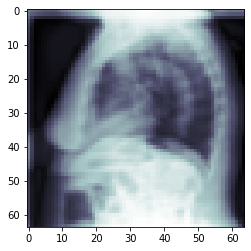

In [23]:
sample = train[5]
plt.imshow(sample['image'].squeeze(0), cmap='bone')
print(sample['label'])

## **Prepare test data**

In [51]:
test_df = pd.read_csv(test_path)
#test_df

In [52]:
images = list(map(str, test_df['target_name']))
test_image_names = []

for image in images:
    image_name = images_path + '/' + image
    test_image_names.append(image_name)

In [53]:
nTestData = len(test_image_names)

## **Model Architecture**

In [28]:
class LungModel(nn.Module):
    def __init__(self,width,height): 
        super(LungModel,self).__init__()  

        numConvs1 = 8
        convSize1 = 5
        numConvs2 = 16
        convSize2 = 3
       
        self.cnv1 = nn.Conv2d(in_channels=1, out_channels=numConvs1, kernel_size=convSize1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnv2 = nn.Conv2d(in_channels=numConvs1, out_channels=numConvs2, kernel_size=convSize2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        denseSize1 = 256
        denseSize2 = 64
      
        self.dense1 = nn.Linear(16*14*14, denseSize1)
        self.dense2 = nn.Linear(denseSize1, denseSize2)
        self.dense3 = nn.Linear(denseSize2, 2)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self,x):

        #print(self.cnv1(x).shape)
        x = F.elu(self.cnv1(x))
        #print(self.maxpool1(x).shape)
        x = self.maxpool1(x)
        #print(self.cnv2(x).shape)
        x = F.elu(self.cnv2(x))
        #print(self.maxpool2(x).shape)
        x = self.maxpool2(x)
        x = x.view(-1,self.num_flat_features(x))
        #print(self.dense1(x).shape)
        x = F.elu(self.dense1(x)) 
        x = self.dropout(x)
        x = F.elu(self.dense2(x)) 
        x = self.dropout(x)
        x = self.dense3(x)        
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [29]:
model = LungModel(imageWidth, imageHeight).to(dev)

In [30]:
train_loader = DataLoader(train, batch_size=10, shuffle=True, drop_last=True)
val_loader = DataLoader(validation, batch_size=10, shuffle=True, drop_last=True)
criterion = torch.nn.BCEWithLogitsLoss()
#optimizer = optim.Adam(model.parameters(), lr=3e-2)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [31]:
num_epochs = 20
CEweights = torch.ones(2).to(dev)
  
for i in range(num_epochs):

    model.train()
    train_loss = 0

    for sample in train_loader:
        image, label = sample['image'], sample['label']
        image, label = image.to(dev), label.to(dev)

        print(label)

        #plt.imshow(image.squeeze(1)[0].cpu(), cmap='bone')
        #plt.show()
        #print(label)

        prediction = model(image)
        print(prediction)
        optimizer.zero_grad()
        loss = F.cross_entropy(prediction, label, weight=CEweights)
        loss.backward()
        optimizer.step() 

        train_loss += loss.item()
      
    val_loss = 0

    model.eval()
    j = 0
    with torch.no_grad():
        for sample in val_loader:
            image, label = sample['image'], sample['label']
            image, label = image.to(dev), label.to(dev)
            prediction = model(image)
            print(j)
            j += 1

            optimizer.zero_grad()
            loss = F.cross_entropy(prediction, label, weight=CEweights)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    print("Epoch = ", i, "; Training loss = ", train_loss, "; Validation loss = ", val_loss)


tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
tensor([[-0.1198, -0.1680],
        [-0.1092, -0.1153],
        [-0.1190, -0.1335],
        [-0.1139, -0.0855],
        [-0.0579, -0.1245],
        [-0.0850, -0.1343],
        [-0.1107, -0.2024],
        [-0.0964, -0.1223],
        [-0.1128, -0.1749],
        [-0.0685, -0.1489]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
tensor([[-0.0714, -0.1969],
        [-0.0253, -0.1517],
        [-0.0614, -0.1727],
        [-0.1119, -0.1655],
        [-0.0613, -0.1593],
        [-0.0777, -0.1069],
        [-0.0829, -0.1397],
        [-0.0817, -0.1792],
        [-0.1253, -0.1151],
        [-0.1174, -0.1921]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')
tensor([[-0.0752, -0.1845],
        [-0.1024, -0.1718],
        [-0.0637, -0.1654],
        [-0.0937, -0.1896],
        [-0.1395, -0.1149],
        [-0.0739, -0.1678],
        [-0.0754, 

KeyboardInterrupt: ignored